In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

from utils import cluster
from utils import plot_utils
from utils.config import TrackerConfig

In [ ]:
config = TrackerConfig()
labeled_nc_folder = config.paths.labeled_nc_folder
csv_folder = config.paths.csv_folder
cao_chains = pd.read_csv(f"{csv_folder}/cao_chains.csv")
clusters_with_chains = pd.read_csv(f'{csv_folder}/clusters_with_chains.csv')
clusters_with_chains.time = pd.to_datetime(clusters_with_chains.time)
ds = xr.open_mfdataset(f"{labeled_nc_folder}/*.nc")
ds['chain'] = xr.zeros_like(ds['labeled_clusters_filtered'])
min_duration = 2
# Filter chains by minimum duration
valid_chains = cao_chains[cao_chains.duration_days > min_duration]

# Collect all dates that belong to valid chains
all_chain_dates = []
for _, row in valid_chains.iterrows():
    dates = pd.date_range(row['start_date'], row['end_date'], freq='D')
    all_chain_dates.extend(dates.date)

# Remove duplicates
all_chain_dates = set(all_chain_dates)
chain_date_strings = [str(date) for date in all_chain_dates]
ds_cao_only = ds.where(ds.time.dt.strftime('%Y-%m-%d').isin(chain_date_strings), drop=True)
ds_cao_only['chain'] = (ds_cao_only['labeled_clusters_filtered'] > 0)
total_cao_days = ds_cao_only['chain'].sum(dim=['time'])



In [20]:
scaled_anomalies = xr.open_dataset(f"{config.paths.nc_folder}/seasonal_anomalies_masked.nc")
scaled_anomalies

<xarray.Dataset> Size: 18GB
Dimensions:         (time: 12554, latitude: 201, longitude: 441)
Coordinates:
  * latitude        (latitude) float32 804B 70.0 69.75 69.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time            (time) datetime64[ns] 100kB 1940-01-01 ... 2022-12-31
Data variables:
    daily_t2_max    (time, latitude, longitude) float32 4GB ...
    daily_t2_min    (time, latitude, longitude) float32 4GB ...
    anomaly         (time, latitude, longitude) float32 4GB ...
    scaled_anomaly  (time, latitude, longitude) float32 4GB ...

In [45]:
# Define analysis regions with consistent box size
box_size = 7.0  # degrees

analysis_regions = {
    'great_plains': {'center_lat': 44, 'center_lon': -99},
    'northwest_us': {'center_lat': 51, 'center_lon': -110},
    'northwest_canada': {'center_lat': 60, 'center_lon': -130},
    'texas': {'center_lat': 33, 'center_lon': -98},
    'southeast': {'center_lat': 33, 'center_lon': -85},
    'midwest': {'center_lat': 42, 'center_lon': -86},
    'northeast': {'center_lat': 44.5, 'center_lon': -76}
}

def extract_regional_timeseries(ds,  center_lat, center_lon, box_size,func='sum'):
    lat_min = center_lat - box_size/2
    lat_max = center_lat + box_size/2
    lon_min = center_lon - box_size/2  
    lon_max = center_lon + box_size/2
    
    regional_data = ds.sel(
        latitude=slice(lat_max, lat_min),  # Note: reversed for latitude
        longitude=slice(lon_min, lon_max)
    )
    
    # Sum CAO days per year in the region
    if func == 'sum':
        annual_cao = regional_data.groupby(regional_data.time.dt.year).sum()
    elif func == 'mean':
        annual_cao = regional_data.groupby(regional_data.time.dt.year).mean()
    elif func == 'min':
        annual_cao = regional_data.groupby(regional_data.time.dt.year).min()
    else:
        annual_cao = regional_data.groupby(regional_data.time.dt.year).sum()
    return annual_cao

def sensitivity_analysis(ds, center_lat, center_lon, box_size, shift_range=1.0):
    """Test robustness by shifting box position"""
    
    shifts = np.arange(-shift_range, shift_range + 0.5, 0.5)  # ±1° in 0.5° steps
    results = {}
    
    for lat_shift in shifts:
        for lon_shift in shifts:
            shifted_lat = center_lat + lat_shift
            shifted_lon = center_lon + lon_shift
            
            timeseries = extract_regional_timeseries(
                ds, f"shift_{lat_shift}_{lon_shift}", 
                shifted_lat, shifted_lon, box_size
            )
            
            results[f"lat{lat_shift:+.1f}_lon{lon_shift:+.1f}"] = timeseries
    
    return results


def region_box(ds, center_lat, center_lon, box_size):
    lat_min = center_lat - box_size/2
    lat_max = center_lat + box_size/2
    lon_min = center_lon - box_size/2  
    lon_max = center_lon + box_size/2
    
    mask = (
        (ds.latitude >=lat_min) & 
        (ds.latitude <=lat_max) &
        (ds.longitude >= lon_min) & 
        (ds.longitude <= lon_max)
    )
    return(mask)

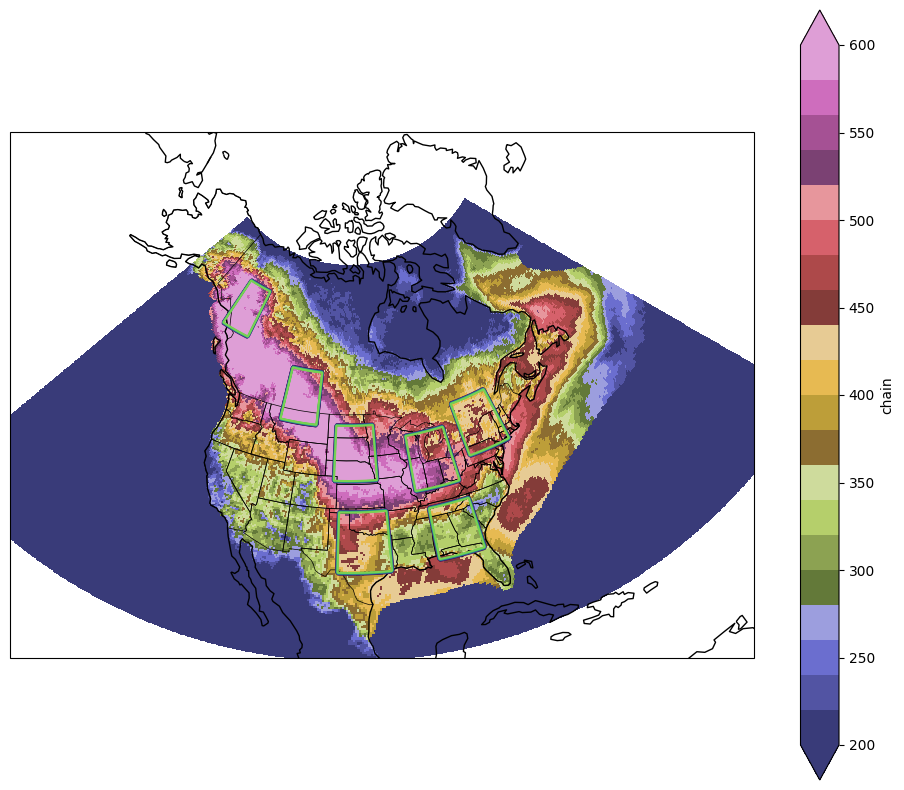

In [110]:
northwest_canada = region_box(total_cao_days,**analysis_regions['northwest_canada'],box_size=7)
great_plains = region_box(total_cao_days,**analysis_regions['great_plains'],box_size=7)
northwest_us = region_box(total_cao_days,**analysis_regions['northwest_us'],box_size=7)

coords1 = {'center_lat': 51, 'center_lon': -110}
region1 = region_box(total_cao_days,**coords1,box_size=7)

coords2 = {'center_lat': 60, 'center_lon': -130}
region2 = region_box(total_cao_days,**coords2,box_size=7)

texas = {'center_lat': 33, 'center_lon': -98}
texas = region_box(total_cao_days,**texas,box_size=7)

southeast = {'center_lat': 33, 'center_lon': -85}
southeast = region_box(total_cao_days,**southeast,box_size=6)

midwest = {'center_lat': 42, 'center_lon': -86}
midwest = region_box(total_cao_days,**midwest,box_size=7)

northeast = {'center_lat': 44.5, 'center_lon': -76}
northeast = region_box(total_cao_days,**northeast,box_size=7)


plt.figure(figsize=(12, 10))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
total_cao_days.plot(cmap="tab20b",transform=ccrs.PlateCarree(),vmin=200,vmax=600)
region1.plot.contour(transform=ccrs.PlateCarree())
northwest_us.plot.contour(transform=ccrs.PlateCarree())
texas.plot.contour(transform=ccrs.PlateCarree())
southeast.plot.contour(transform=ccrs.PlateCarree())
midwest.plot.contour(transform=ccrs.PlateCarree())
great_plains.plot.contour(transform=ccrs.PlateCarree())
northwest_canada.plot.contour(transform=ccrs.PlateCarree())
northeast.plot.contour(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

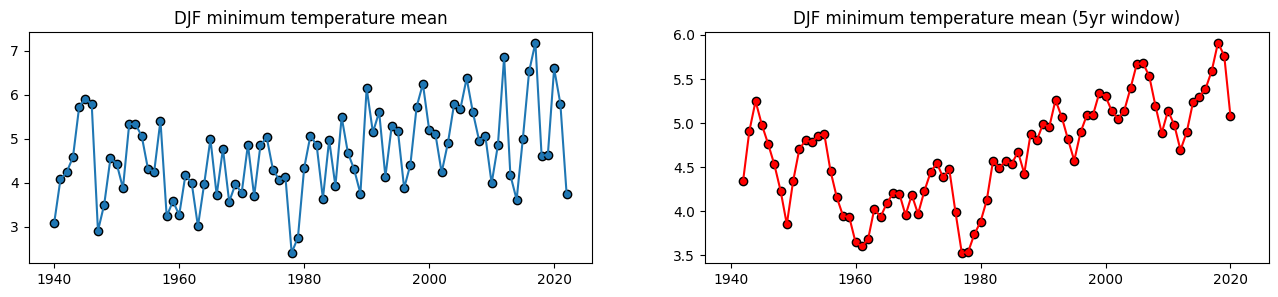

In [115]:
region = 'texas'
coords = analysis_regions[region]
tmin_mean = extract_regional_timeseries((scaled_anomalies['daily_t2_min']-273.15),  **coords, box_size = 6,func='mean')
tmin_mean = tmin_mean.mean(dim=['latitude', 'longitude'])

df_plot = pd.DataFrame({'values': tmin_mean.values,'years': tmin_mean.year.values})
df_plot.index = df_plot.years
df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(df_plot["values"])
ax[0].scatter(df_plot.index,df_plot["values"],c="#1f77b4",edgecolors='black')
ax[0].set_title('DJF minimum temperature mean');
#ax[0].set_ylabel('Temperature [C]');

ax[1].plot(df_plot["rolling"],color="#FF0000")
ax[1].scatter(df_plot.index,df_plot['rolling'],c="#FF0000",edgecolors='black')
ax[1].set_title('DJF minimum temperature mean (5yr window)');
#ax[1].set_ylabel('CAO index [C]');

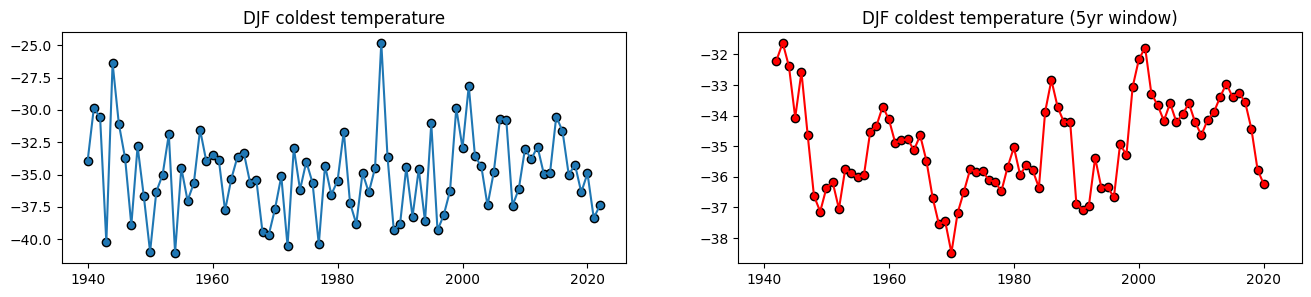

In [90]:
tmin_min = extract_regional_timeseries((scaled_anomalies['daily_t2_min']-273.15),  **coords, box_size = 6,func='min')
tmin_min = tmin_min.mean(dim=['latitude', 'longitude'])

df_plot = pd.DataFrame({'values': tmin_min.values,'years': tmin_min.year.values})
df_plot.index = df_plot.years
df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(df_plot["values"])
ax[0].scatter(df_plot.index,df_plot["values"],c="#1f77b4",edgecolors='black')
ax[0].set_title('DJF coldest temperature');
#ax[0].set_ylabel('Temperature [C]');

ax[1].plot(df_plot["rolling"],color="#FF0000")
ax[1].scatter(df_plot.index,df_plot['rolling'],c="#FF0000",edgecolors='black')
ax[1].set_title('DJF coldest temperature (5yr window)');
#ax[1].set_ylabel('CAO index [C]');

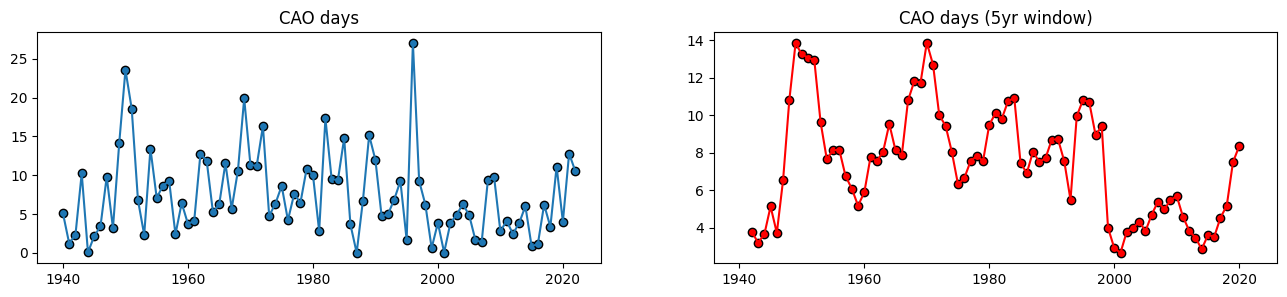

In [ ]:
n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **coords, box_size = 6,func='sum')
n_cao = n_cao.mean(dim=['latitude', 'longitude'])

df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
df_plot.index = df_plot.years
df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()

fig, ax = plt.subplots(1,2,sharex=True,figsize=(16, 3))

ax[0].plot(df_plot["values"])
ax[0].scatter(df_plot.index,df_plot["values"],c="#1f77b4",edgecolors='black')
ax[0].set_title('CAO days');
#ax[0].set_ylabel('Temperature [C]');

ax[1].plot(df_plot["rolling"],color="#FF0000")
ax[1].scatter(df_plot.index,df_plot['rolling'],c="#FF0000",edgecolors='black')
ax[1].set_title('CAO days (5yr window)');
#ax[1].set_ylabel('CAO index [C]');

# cao days

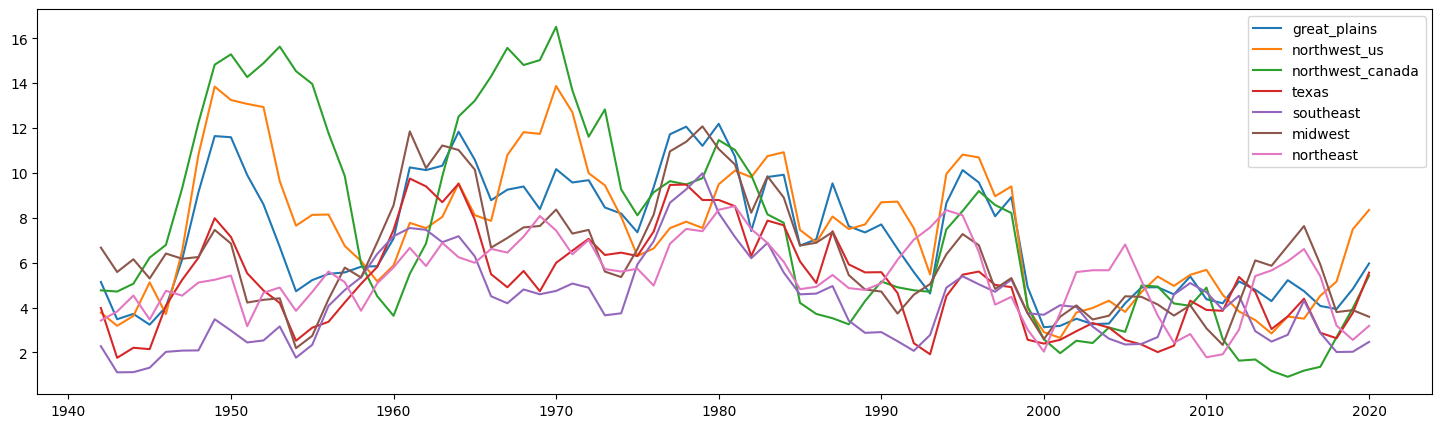

In [93]:
plt.figure(figsize=(18,5))
for region, coords in analysis_regions.items():
    n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **coords, box_size = 6,func='sum')
    n_cao = n_cao.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()

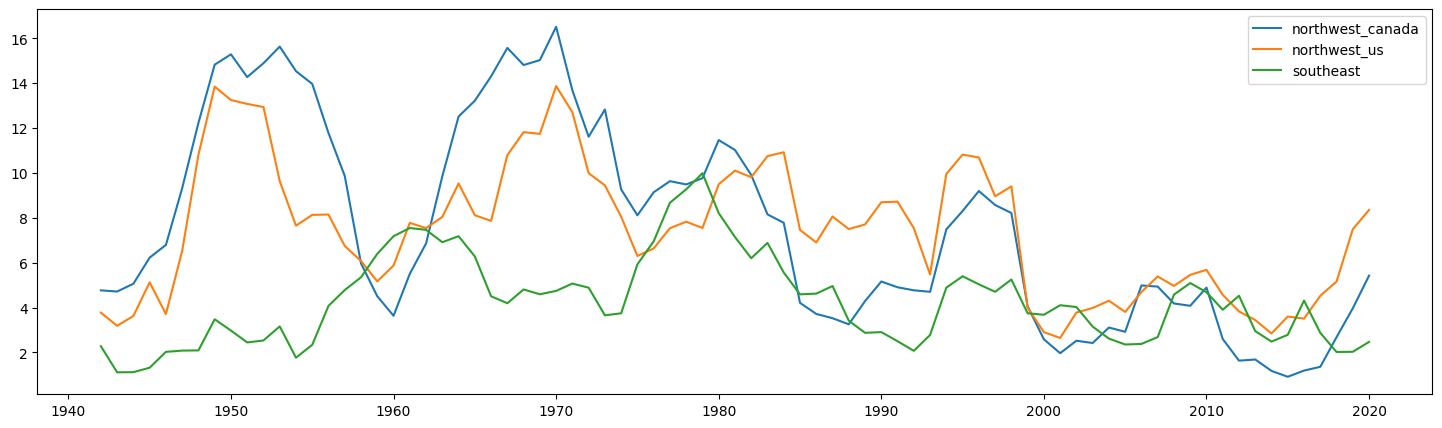

In [95]:
plt.figure(figsize=(18,5))
for region in ['northwest_canada','northwest_us','southeast']:
    n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **analysis_regions[region], box_size = 6,func='sum')
    n_cao = n_cao.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()


#    'great_plains': {'center_lat': 44, 'center_lon': -99},
#    'northwest_us': {'center_lat': 51, 'center_lon': -110},
#    'northwest_canada': {'center_lat': 60, 'center_lon': -130},
#    'texas': {'center_lat': 33, 'center_lon': -98},
#    'southeast': {'center_lat': 33, 'center_lon': -85},
#    'midwest': {'center_lat': 42, 'center_lon': -86},
#    'northeast': {'center_lat': 44.5, 'center_lon': -76}

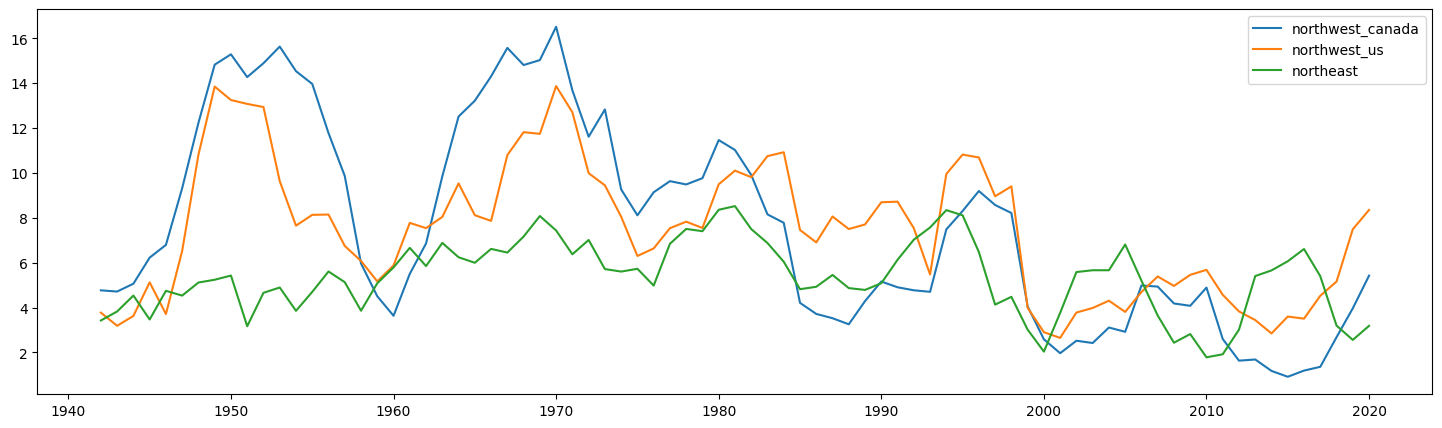

In [100]:
plt.figure(figsize=(18,5))
for region in ['northwest_canada','northwest_us','northeast']:
    n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **analysis_regions[region], box_size = 6,func='sum')
    n_cao = n_cao.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()

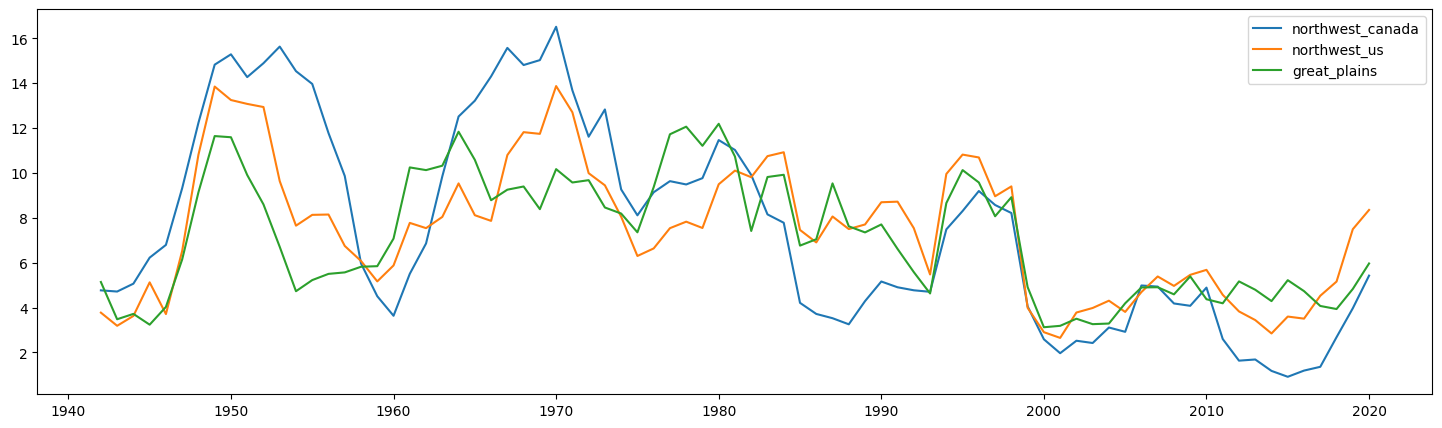

In [113]:
plt.figure(figsize=(18,5))
for region in ['northwest_canada','northwest_us','great_plains']:
    n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **analysis_regions[region], box_size = 6,func='sum')
    n_cao = n_cao.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()

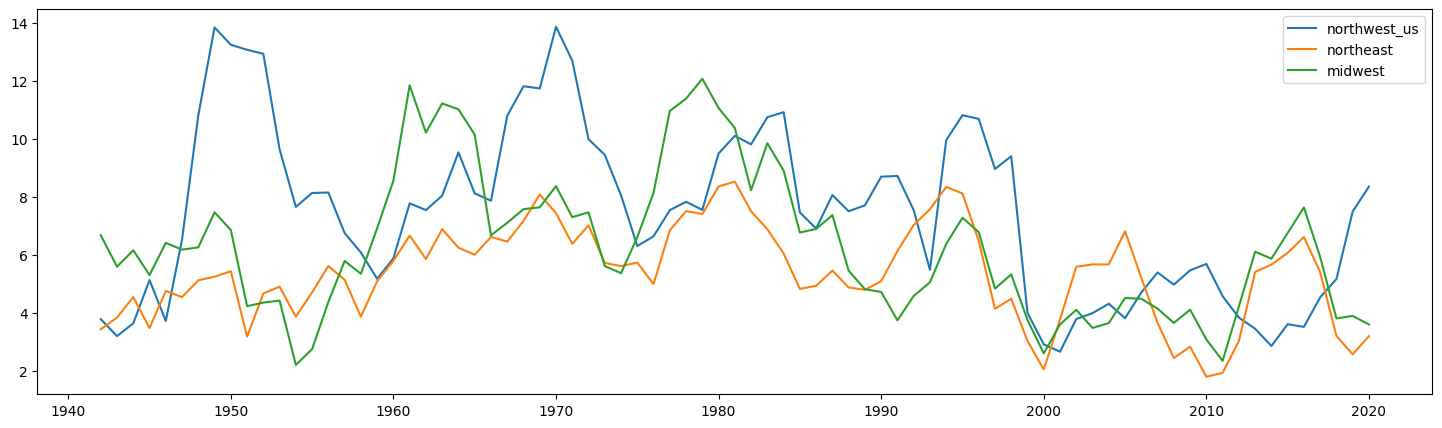

In [106]:
plt.figure(figsize=(18,5))
for region in ['northwest_us','northeast','midwest']:
    n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **analysis_regions[region], box_size = 6,func='sum')
    n_cao = n_cao.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()

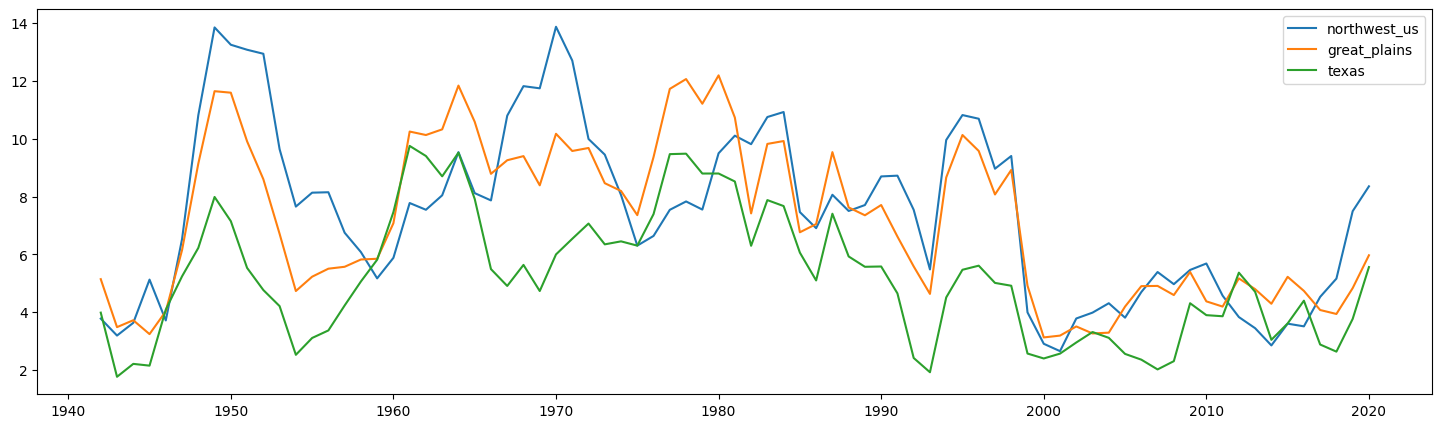

In [108]:
plt.figure(figsize=(18,5))
for region in ['northwest_us','great_plains','texas']:
    n_cao = extract_regional_timeseries(ds_cao_only['chain'],  **analysis_regions[region], box_size = 6,func='sum')
    n_cao = n_cao.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': n_cao.values,'years': n_cao.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()

# tmin

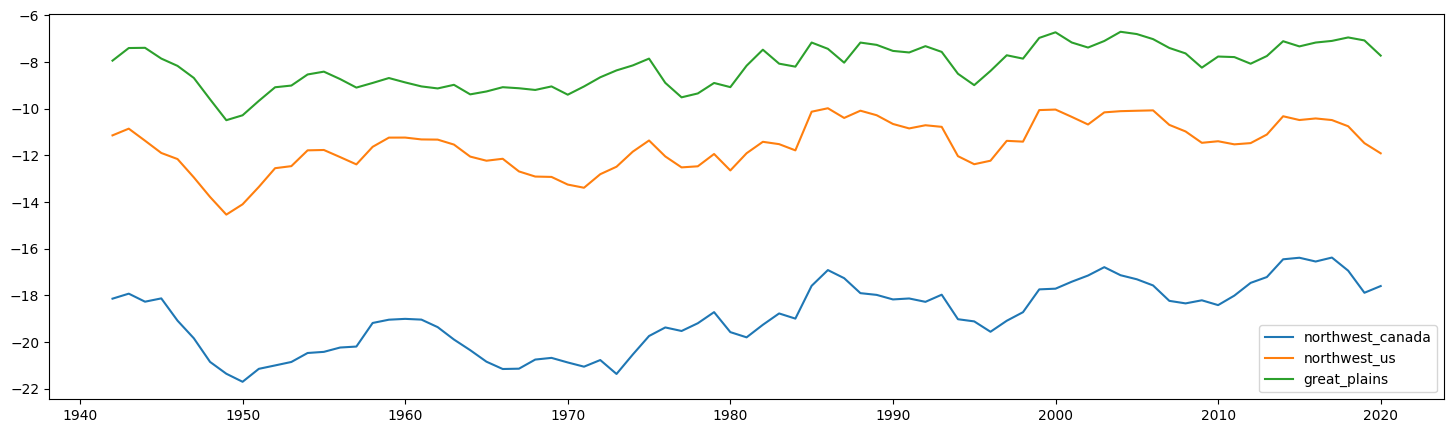

In [114]:
plt.figure(figsize=(18,5))
for region in ['northwest_canada','northwest_us','great_plains']:
    tmin_mean = extract_regional_timeseries((scaled_anomalies['daily_t2_min']-273.15),  **analysis_regions[region], box_size = 6,func='mean')
    tmin_mean = tmin_mean.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': tmin_mean.values,'years': tmin_mean.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()


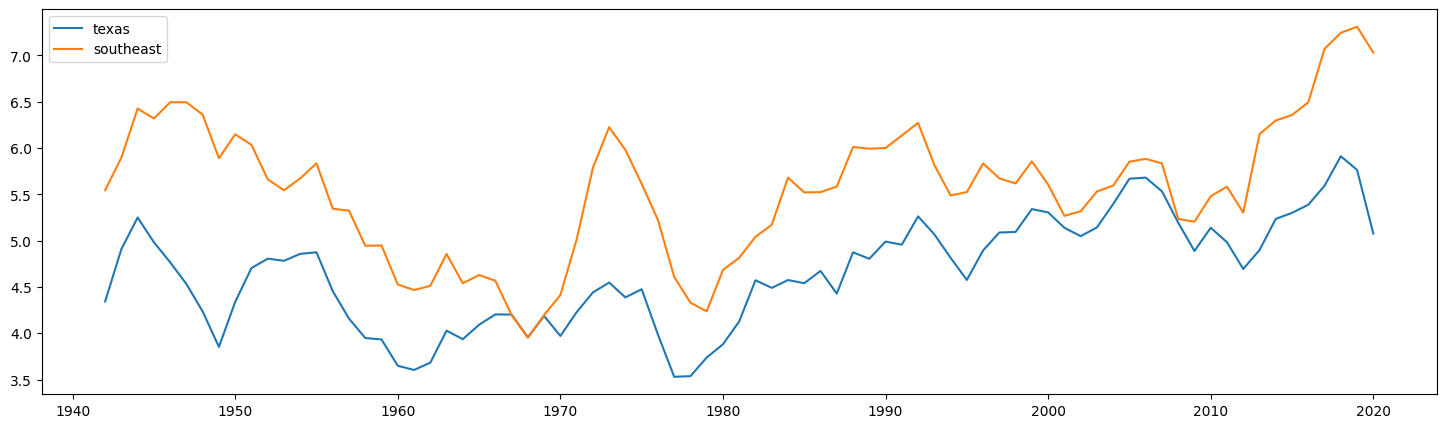

In [112]:
plt.figure(figsize=(18,5))
for region in ['texas','southeast']:
    tmin_mean = extract_regional_timeseries((scaled_anomalies['daily_t2_min']-273.15),  **analysis_regions[region], box_size = 6,func='mean')
    tmin_mean = tmin_mean.mean(dim=['latitude', 'longitude'])
    df_plot = pd.DataFrame({'values': tmin_mean.values,'years': tmin_mean.year.values})
    df_plot.index = df_plot.years
    df_plot["rolling"] = df_plot["values"].rolling(5,center=True).mean()
    plt.plot(df_plot["rolling"],label=region)

plt.legend()
plt.show()